In [ ]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, precision_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import recall_score, classification_report, confusion_matrix, precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Local modules
from src.data import get_data, split_data, remove_correlated_features

In [2]:
# Load data from openML into a DataFrame
df = get_data()

## Exploratory Data Analysis

In [3]:
df.shape

(76020, 370)

In [4]:
df.dtypes.unique()

array([dtype('int64'), dtype('uint8'), dtype('float64')], dtype=object)

In [5]:
# Discover dataset's shape, data types and size
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 370 entries, var3 to TARGET
dtypes: float64(115), int64(39), uint8(216)
memory usage: 105.0 MB


- There are 369 features and 76k rows. 
- All variables are numeric.

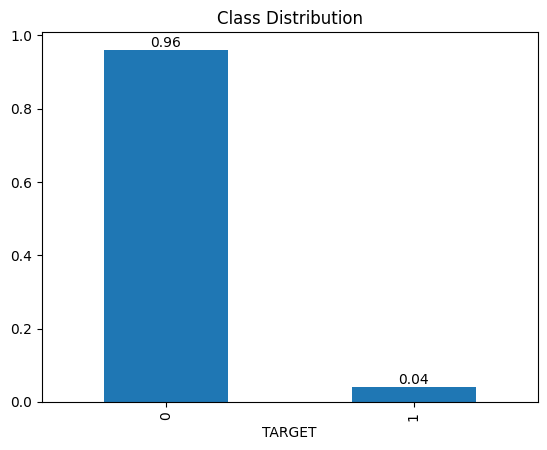

In [6]:
# Understand distribution in the TARGET column
ax = df.TARGET.value_counts(normalize=True).plot(kind='bar')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=0)
plt.title('Class Distribution')
plt.show()

In [7]:
# Check missing values
df.isna().sum().sort_values(ascending=False).head()

var3                       0
imp_trasp_var17_in_ult1    0
ind_var7_emit_ult1         0
imp_venta_var44_ult1       0
imp_venta_var44_hace3      0
dtype: int64

In [8]:
# There are too many features, there is a high probability of not all being useful - Many correlated values
# Set a threshold of absolute correlation == 0.9, anything above that is flagged
corr = df.corr(numeric_only=True)

high_corr = (corr.abs() > 0.9) & (corr.abs() < 1)
high_corr.sum().sort_values(ascending=False).head(20)

saldo_medio_var13_medio_ult3     8
saldo_medio_var13_medio_hace2    8
saldo_medio_var17_hace2          6
saldo_var31                      6
saldo_medio_var17_ult1           6
saldo_var6                       6
saldo_var29                      6
imp_aport_var17_hace3            6
saldo_medio_var17_ult3           6
saldo_medio_var17_hace3          6
saldo_var17                      6
saldo_var34                      6
num_var1                         5
saldo_medio_var12_ult3           5
ind_var13_corto_0                5
ind_var26_cte                    5
ind_var25_cte                    5
ind_var24                        5
ind_var1                         5
saldo_medio_var12_ult1           5
dtype: int64

In [9]:
# Since there are columns with multiple highly correlated values, we can keep only one for each pair and reduce the non-important ones

df_reduced, dropped = remove_correlated_features(df)
print(f"Dropped {len(dropped)} correlated features.")
print(df.shape, "→", df_reduced.shape)

Dropped 166 correlated features.
(76020, 370) → (76020, 204)


## Data split

In [10]:
# Split the data in 60/20/20 using sklearn's built-in function
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_reduced)

## Model selection

- This is a classification problem, so 4 different models are trained and compared to find the best performing one:
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - XGBoost

- The challenge used the roc_auc metric as criteria to select the best model, but the target variable is highly imbalanced so the most recommended metric is pr-auc. Both are measured and used to select the best model.

### Logistic Regression

Used LogisticRegressionCV beacuse it has a built-in option to compare different Cs(regularizations).

In [11]:
# There are many numerical columns with different scales
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Used LogisticRegressionCV model because it is more advanced than its original version 
# Set multiple regularization values so it can pick the best one.
# Defined 5 folds (cv) to find the sweet spot of accuracy-performance
model = LogisticRegressionCV(
    Cs=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    cv=5,
    scoring='average_precision',
    max_iter=10000,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

,Cs,"[0.0001, 0.001, ...]"
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,'average_precision'
,solver,'lbfgs'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,-1


In [12]:
# Use model on validation df and measure its roc_auc and pr_auc
y_pred = model.predict_proba(X_val_scaled)[:,1]
roc_lr_val = roc_auc_score(y_val, y_pred)
pr_lr_val = average_precision_score(y_val, y_pred)

In [13]:
# Use model on test df and measure its roc_auc and pr_auc
y_pred = model.predict_proba(X_test_scaled)[:,1]
roc_lr_test = roc_auc_score(y_test, y_pred)
pr_lr_test = average_precision_score(y_test, y_pred)

### Decision Trees

Used DecisionTreeClassifier as recommended in the Zoomcamp

In [14]:
# Created a grid of hyperparameters to evaluate using GridSearchCV
param_grid = {
    'max_depth': [5, 6, 7, 8],
    'min_samples_leaf': [100, 200, 300, 400, 500, 600],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=666)

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
print("Best params:", grid_dt.best_params_)
print("Best AUC:", grid_dt.best_score_)

Best params: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 400, 'min_samples_split': 2}
Best AUC: 0.15720052268980877


In [15]:
# Use model on validation df and measure its roc_auc and pr_auc
y_pred = grid_dt.predict_proba(X_val)[:,1]
roc_dt_val = roc_auc_score(y_val, y_pred)
pr_dt_val = average_precision_score(y_val, y_pred)

In [16]:
# Use model on test df and measure its roc_auc and pr_auc
y_pred = grid_dt.predict_proba(X_test)[:,1]
roc_dt_test = roc_auc_score(y_test, y_pred)
pr_dt_test = average_precision_score(y_test, y_pred)

### Random Forest

Used RandomForestClassifier as recommended in the Zoomcamp

In [17]:
# Created a grid of hyperparameters to evaluate using GridSearchCV
param_dist = {
    "n_estimators": range(10, 201, 10),
    "max_depth": [5, 10, 15, None],
    "min_samples_leaf": range(10, 201, 10),
    "min_samples_split": range(10, 201, 10)
}

rf = RandomForestClassifier()

search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=80, cv=3, scoring="average_precision",
    n_jobs=-1, random_state=666, verbose=1
)
search_rf.fit(X_train, y_train)
print("Best params:", search_rf.best_params_)
print("Best AUC:", search_rf.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Best params: {'n_estimators': 130, 'min_samples_split': 150, 'min_samples_leaf': 10, 'max_depth': 15}
Best AUC: 0.17507902598111436


In [18]:
# Use model on validation df and measure its roc_auc and pr_auc
y_pred = search_rf.predict_proba(X_val)[:,1]
roc_rf_val = roc_auc_score(y_test, y_pred)
pr_rf_val = average_precision_score(y_test, y_pred)

In [19]:
# Use model on test df and measure its roc_auc and pr_auc
y_pred = search_rf.predict_proba(X_test)[:,1]
roc_rf_test = roc_auc_score(y_test, y_pred)
pr_rf_test = average_precision_score(y_test, y_pred)

### XGBoost

Used XGBClassifier because it offers better integrations with sklearn ecosystem than regular xgb

In [20]:
# Created a grid of hyperparameters to evaluate using RandomizedSearchCV
# GridSearchCV was too slow in this model due to the large amount of parameter options
param_dist = {
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [100, 150, 200, 250, 300, 350, 400],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 3, 4, 5, 6]
}

xgb = XGBClassifier(
    objective = 'binary:logistic',
    eval_metric='aucpr',
    random_state=666
)

search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=80,
    cv=5,
    scoring='average_precision',
    n_jobs=-1,
    random_state=666,
    verbose=1
)

search_xgb.fit(X_train, y_train)

print("Best params:", search_xgb.best_params_)
print("Best AUC:", search_xgb.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best params: {'subsample': 0.6, 'n_estimators': 350, 'min_child_weight': 2, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best AUC: 0.18973317410946164


In [62]:
search_xgb.best_params_

{'subsample': 0.6,
 'n_estimators': 350,
 'min_child_weight': 2,
 'max_depth': 7,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [ ]:
# Use model on validation df and measure its roc_auc and pr_auc
y_pred = search_xgb.predict_proba(X_val)[:,1]
roc_xgb_val = roc_auc_score(y_val, y_pred)
pr_xgb_val = average_precision_score(y_val, y_pred)

In [ ]:
# Use model on test df and measure its roc_auc and pr_auc
y_pred = search_xgb.predict_proba(X_test)[:,1]
roc_xgb_test = roc_auc_score(y_test, y_pred)
pr_xgb_test = average_precision_score(y_test, y_pred)

## Comparison

In [ ]:
# Created a DataFrame with the roc_auc_score and pr-auc of all models to find the best performing one
auc_scores = pd.DataFrame(
    [
        ['LogisticRegressionCV', roc_lr_val, roc_lr_test, pr_lr_val, pr_lr_test],
        ['DecisionTreeClassifier', roc_dt_val, roc_dt_test, pr_dt_val, pr_dt_test],
        ['RandomForestClassifier', roc_rf_val, roc_rf_test, pr_rf_val, pr_rf_test],
        ['XGBClassifier', roc_xgb_val, roc_xgb_test, pr_xgb_val, pr_xgb_test]
    ],
    columns = ['model', 'val_roc', 'test_roc', 'val_pr', 'test_pr']
)

auc_scores['roc_var'] = auc_scores['test_roc'] - auc_scores['val_roc']
auc_scores['pr_var'] = auc_scores['test_pr'] - auc_scores['val_pr']
auc_scores['rank'] = auc_scores['test_pr'].rank(ascending=False)

auc_scores = auc_scores.round(3)

auc_scores.sort_values(by='rank')

,model,val_roc,test_roc,val_pr,test_pr,roc_var,pr_var,rank
3,XGBClassifier,0.834,0.845,0.195,0.193,0.011,-0.002,1.0
2,RandomForestClassifier,0.521,0.830,0.043,0.192,0.309,0.149,2.0
1,DecisionTreeClassifier,0.812,0.826,0.155,0.156,0.014,0.001,3.0
0,LogisticRegressionCV,0.793,0.803,0.136,0.146,0.010,0.010,4.0


The best model is XGBClassifier because it has the best ROC and PR results and demonstrates low variation between validation and testing predictions.

## Model validation and adjustment

In [ ]:
# Re-train the XGB model in the full_train dataset (X_train+X_val) and check roc_auc_score
best_xgb = search_xgb.best_estimator_

final_xgb = best_xgb.fit(pd.concat([X_train, X_val]),
                       pd.concat([y_train, y_val]))

y_test_pred = final_xgb.predict_proba(X_test)[:,1]

print('Final test ROC-AUC score:', roc_auc_score(y_test, y_test_pred))
print("Final test PR-AUC score:", average_precision_score(y_test, y_test_pred))

Final test ROC-AUC scores: 0.8479164893900213
Final test PR-AUC scores: 0.1940944862815353


In [53]:
# 0.5 is the standard threshold for binary classification
y_pred = (y_test_pred > 0.5).astype(int)

print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))
print()
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[14602     0]
 [  601     1]]

Classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     14602
           1       1.00      0.00      0.00       602

    accuracy                           0.96     15204
   macro avg       0.98      0.50      0.49     15204
weighted avg       0.96      0.96      0.94     15204



The model shows high performance due to the target variable's high imbalance, but it can improve with a better threshold.

In [ ]:
# Used f1 score to find the best threshold for this model
prec, rec, thr = precision_recall_curve(y_test, y_test_pred)
f1_scores = 2 * prec * rec / (prec + rec)

best_thr = thr[f1_scores.argmax()]
print(f"Optimal threshold: {best_thr:.3f}")

Optimal threshold: 0.136


In [54]:
# Calculate confusion matrix with best threshold
y_pred = (y_test_pred > best_thr).astype(int)

print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))
print()
print('Classification report')
print(classification_report(y_test, y_pred))

Confusion matrix
[[13477  1125]
 [  310   292]]

Classification report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     14602
           1       0.21      0.49      0.29       602

    accuracy                           0.91     15204
   macro avg       0.59      0.70      0.62     15204
weighted avg       0.95      0.91      0.92     15204



A threshold of 0.136 increases true positive detection but also raises false positives—a trade-off that may be acceptable if the bank can retain the dissatisfied customers it identifies.

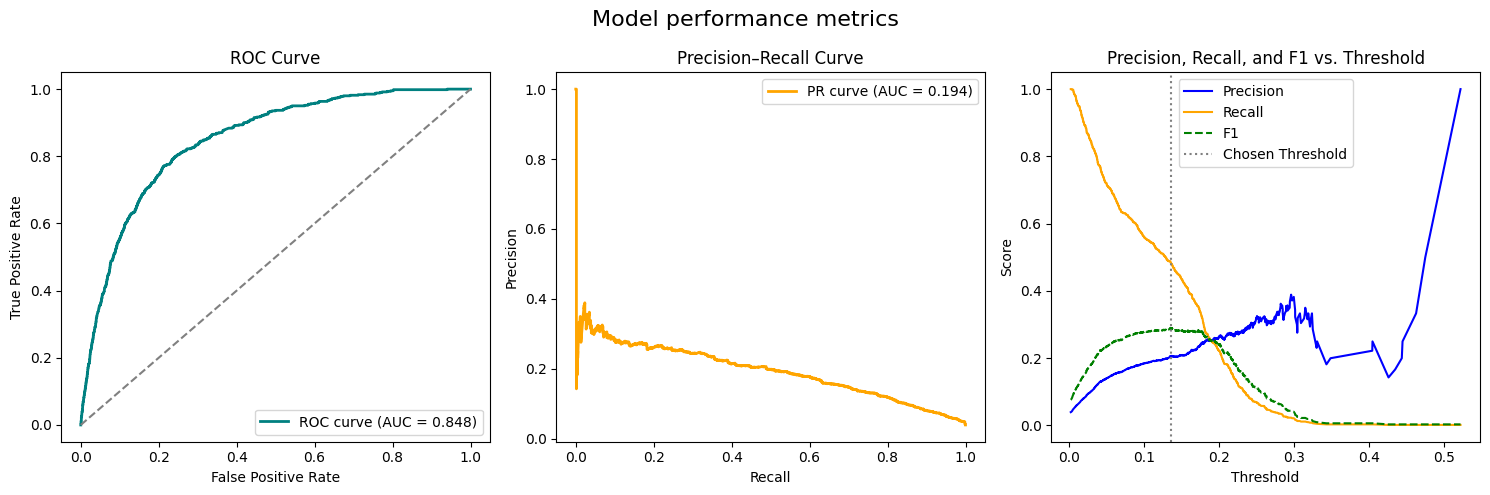

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_test, y_test_pred)
prec, rec, thr = precision_recall_curve(y_test, y_test_pred)
f1_scores = 2 * prec * rec / (prec + rec)

fig, axis = plt.subplots(1, 3, figsize=(15, 5))

# ROC curve
axis[0].plot(fpr, tpr, color='teal', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
axis[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axis[0].set_xlabel("False Positive Rate")
axis[0].set_ylabel("True Positive Rate")
axis[0].set_title("ROC Curve")
axis[0].legend(loc="lower right")

# PR curve
axis[1].plot(rec, prec, color='orange', lw=2, label=f"PR curve (AUC = {pr_auc:.3f})")
axis[1].set_xlabel("Recall")
axis[1].set_ylabel("Precision")
axis[1].set_title("Precision–Recall Curve")
axis[1].legend(loc="upper right")

# Precision, Recall, F1
axis[2].plot(thr, prec[:-1], label="Precision", color='blue')
axis[2].plot(thr, rec[:-1], label="Recall", color='orange')
axis[2].plot(thr, f1_scores[:-1], label="F1", color='green', linestyle='--')
axis[2].axvline(x=0.136, color='gray', linestyle=':', label="Chosen Threshold")
axis[2].set_xlabel("Threshold")
axis[2].set_ylabel("Score")
axis[2].set_title("Precision, Recall, and F1 vs. Threshold")
axis[2].legend()

fig.suptitle('Model performance metrics', fontsize=16)
plt.tight_layout()
plt.show()

In [60]:
# Validate feature importance, we don't want a single feature with over 40% of weight in the model
fi = (
    pd.DataFrame({
        "feature": X_train.columns,
        "importance": final_xgb.feature_importances_
    })
    .sort_values(by="importance", ascending=False)
    .reset_index(drop=True)
)

fi.head()

,feature,importance
0,ind_var30,0.154305
1,num_var30,0.094848
2,saldo_var30,0.058357
3,var15,0.038772
4,num_var30_0,0.029241


__Model Evaluation Summary__

- __ROC-AUC:__ 0.848 - strong overall ranking ability.
- __PR-AUC:__ 0.194 - 5x better than random (4%) for minority-class detection.
- __Optimal threshold:__ 0.136 - balances recall ≈ 0.49 and precision ≈ 0.21.
- __Top feature importance:__ 0.154 - no single variable dominates, stable model.